In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import numpy as np
import pandas as pd

# Load the CSV file into a DataFrame
nodes_df = pd.read_csv('nodes.csv')
# Load the edges.csv file into a DataFrame
edges_df = pd.read_csv('edges_flows.csv')

def create_graph(nodes_df, edges_df, migration_year):
    graph = nx.DiGraph()

    # Add nodes
    for index, row in nodes_df.iterrows():
        graph.add_node(row['Label'], name=row['Abb'])

    # Add edges with weights and attributes for the specific year
    for index, row in edges_df.iterrows():
        source = row['source']
        target = row['target']
        weight = row[migration_year]
        if weight != 0:
            female_ratio = row[migration_year.replace('total', 'female')] / weight
        else:
            female_ratio = 0
        graph.add_edge(source, target, weight=weight, female_ratio=female_ratio)

    # Clean up the graph (removing low weight edges and isolated nodes)
    mean_weight = np.mean([d['weight'] for _, _, d in graph.edges(data=True)])
    print(f'Mean weight: {mean_weight}')
    # remove_low_weight_edges(graph, mean_weight)
    # remove_isolated_nodes(graph)
    return graph

def visualize_graph(graph, nodes_df, title):
    node_sizes = [graph.degree(n, weight='weight')/5000 for n in graph.nodes()]
    edge_weights = [d['weight'] / 100000 for _, _, d in graph.edges(data=True)]

    # Position, size, and labels
    node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graph.nodes}
    labels = get_high_degree_labels(graph, nodes_df, 100000)

    # Edge colors based on female ratio
    female_ratios = np.array([d['female_ratio'] for _, _, d in graph.edges(data=True)])
    norm = mcolors.Normalize(vmin=female_ratios.min(), vmax=female_ratios.max())
    cmap = plt.get_cmap('magma')
    edge_colors = [cmap(norm(d['female_ratio'])) for _, _, d in graph.edges(data=True)]

    # Visualization
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_sizes, node_color='red', alpha=0.7)
    nx.draw_networkx_edges(graph, node_positions, width=edge_weights, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(graph, node_positions, labels=labels, font_size=12)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical', label='Female Ratio')
    plt.show()

def remove_low_weight_edges(graph, threshold):
    edges_to_remove = [(u, v) for u, v, d in graph.edges(data=True) if d['weight'] < threshold]
    graph.remove_edges_from(edges_to_remove)

def remove_isolated_nodes(graph):
    nodes_to_remove = [n for n in graph.nodes() if graph.degree(n) == 0]
    graph.remove_nodes_from(nodes_to_remove)

def get_high_degree_labels(graph, nodes_df, threshold=100000):
    return {n: data['Abb'] for n, data in nodes_df.set_index('Label').iterrows() 
            if n in graph.nodes() and (graph.degree(n, weight='weight') > threshold )}

# Main execution loop for each migration year
migration_years = [ 'migration_1995_total', 'migration_2000_total', 'migration_2005_total', 'migration_2010_total', 'migration_2015_total']
graphs =[]
for year in migration_years:
    # Create a separate graph for each year and store it in a dictionary
    graph = create_graph(nodes_df, edges_df, year)
    # Visualize the graph
    # visualize_graph(graph, nodes_df, year)
    graphs.append(graph)

Mean weight: 3124.0674207338798
Mean weight: 2759.10402565016
Mean weight: 3200.539989312433
Mean weight: 3692.077841111507
Mean weight: 2743.3322052012827


### Extracting BB networks using the disparity filter

In [2]:
from scipy import integrate


def disparity_filter(G, alpha=0.05):
    # Create an empty graph for the backbone
    B = nx.Graph()

    for node in G.nodes(data=True):
        node_id = node[0]  # Node identifier
        node_attr = node[1]  # Node attributes

        # Add the node to the backbone graph with its attributes
        B.add_node(node_id, **node_attr)

        # Calculate the total weight (strength) of the node
        s = sum([G[node_id][neighbor]['weight'] for neighbor in G.neighbors(node_id)])
        k = G.degree(node_id)

        for neighbor in G.neighbors(node_id):
            weight = G[node_id][neighbor]['weight']
            p_ij = weight / s

            # Calculate the disparity measure
            alpha_ij = 1 - (k - 1) * integrate.quad(lambda x: (1 - x)**(k - 2), 0, p_ij)[0]

            # Add edge to the backbone if significant, with its attributes
            if alpha_ij < alpha:
                edge_attr = G[node_id][neighbor]
                B.add_edge(node_id, neighbor, **edge_attr)

    return B


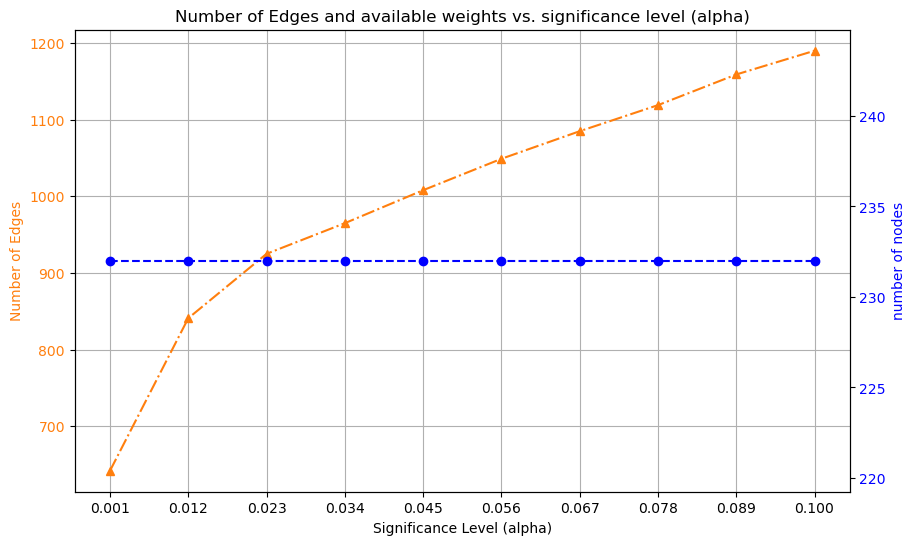

"# Plotting\nplt.figure(figsize=(10, 6))\nplt.plot(alphas, edge_counts, marker='o')\nplt.xlabel('Alpha')\nplt.ylabel('Number of Edges in Backbone')\nplt.title('Backbone Size vs. Alpha')\nplt.grid(True)\nplt.show()"

In [3]:
# Example graph (use one of your migration graphs)
graph = graphs[0]  # Assuming graphs is a list of your migration network graphs

# Define a range of alpha values
alphas = np.linspace(0.001, 0.1, 10)  # Adjust the range and step as needed
edge_counts = []
node_counts = []
weights_availability = [] 

for alpha in alphas:
    num_edges = disparity_filter(graph, alpha).number_of_edges()
    num_nodes = disparity_filter(graph, alpha).number_of_nodes()
    # weight_ratio = sum([disparity_filter(graph, alpha)[u][v]['weight'] for u, v in disparity_filter(graph, alpha).edges()]) / sum([graph[u][v]['weight'] for u, v in graph.edges()])

    # weights_availability.append(weight_ratio)
    edge_counts.append(num_edges)
    node_counts.append(num_nodes)

# Creating the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the number of edges on the primary y-axis
ax1.plot(alphas,edge_counts , color='#ff7f0e', marker='^', linestyle='-.', label='Number of edges')
ax1.set_xlabel('Significance Level (alpha)')
ax1.set_ylabel('Number of Edges', color='#ff7f0e')
ax1.tick_params(axis='y', labelcolor='#ff7f0e')

# Setting x-axis ticks and labels
ax1.set_xticks(alphas)

# Creating a secondary y-axis for the number of nodes
ax2 = ax1.twinx()
ax2.plot(alphas, node_counts, color='blue', marker='o', linestyle='--', label='Number of nodes')
ax2.set_ylabel('number of nodes', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding a title and grid
plt.title('Number of Edges and available weights vs. significance level (alpha)')
ax1.grid(True)

# Showing the plot
plt.show()

"""# Plotting
plt.figure(figsize=(10, 6))
plt.plot(alphas, edge_counts, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Number of Edges in Backbone')
plt.title('Backbone Size vs. Alpha')
plt.grid(True)
plt.show()"""


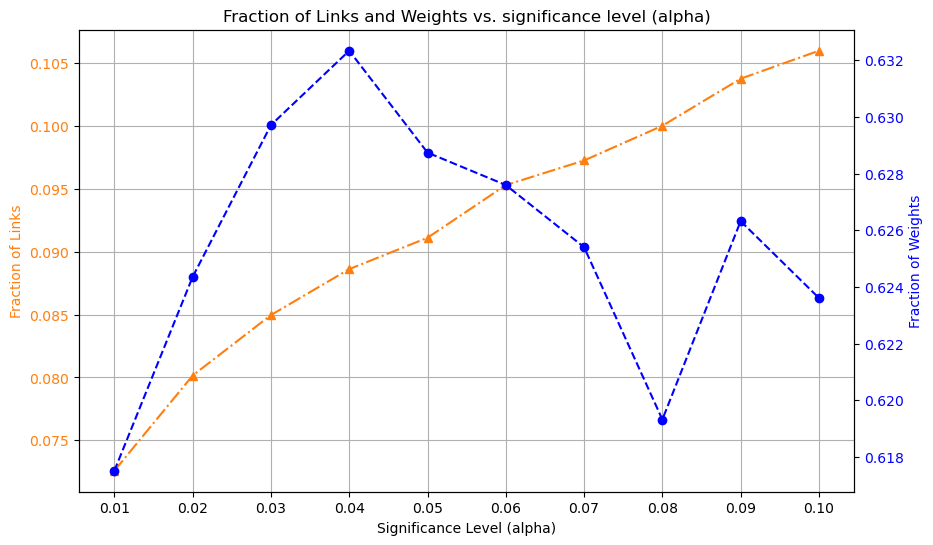

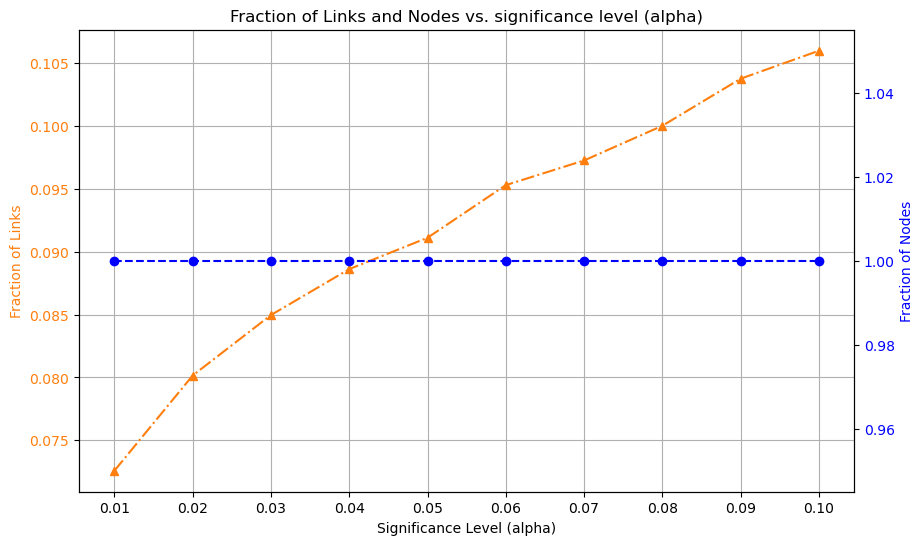

In [4]:
# difining the fraction of links in the backbone network to the total number of links in the original network
def fraction_of_links_in_backbone(G, alpha=0.05):
    B = disparity_filter(G, alpha)
    return B.number_of_edges() / G.number_of_edges()

# defining the fraction of weights in the backbone network to the total weights in the original network
def fraction_of_weights_in_backbone(G, alpha=0.05):
    B = disparity_filter(G, alpha)
    return sum([B[u][v]['weight'] for u, v in B.edges()]) / sum([G[u][v]['weight'] for u, v in G.edges()])

# defining the fraction of nodes in the backbone network to the total nodes in the original network
def fraction_of_nodes_in_backbone(G, alpha=0.05):
    B = disparity_filter(G, alpha)
    return B.number_of_nodes() / G.number_of_nodes()



# plotting the fraction of available weights in the backbone network against the fraction of links in the backbone network for different values of alpha
# Example graph (use one of your migration graphs)
graph = graphs[0]  # Assuming graphs is a list of your migration network graphs

# Define a range of alpha values
alphas = np.linspace(0.01, 0.1, 10)  # Adjust the range and step as needed
fraction_of_links = []
fraction_of_weights = []
fraction_of_nodes = []

for alpha in alphas:
    fraction_of_links.append(fraction_of_links_in_backbone(graph, alpha))
    fraction_of_weights.append(fraction_of_weights_in_backbone(graph, alpha))
    fraction_of_nodes.append(fraction_of_nodes_in_backbone(graph, alpha))

# Creating the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the fraction of links on the primary y-axis
ax1.plot(alphas, fraction_of_links, color='#ff7f0e', marker='^', linestyle='-.', label='Fraction of links')
ax1.set_xlabel('Significance Level (alpha)')
ax1.set_ylabel('Fraction of Links', color='#ff7f0e')
ax1.tick_params(axis='y', labelcolor='#ff7f0e')

# Setting x-axis ticks and labels
ax1.set_xticks(alphas)

# Creating a secondary y-axis for the fraction of weights
ax2 = ax1.twinx()
ax2.plot(alphas, fraction_of_weights, color='blue', marker='o', linestyle='--', label='Fraction of weights')
ax2.set_ylabel('Fraction of Weights', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding a title and grid
plt.title('Fraction of Links and Weights vs. significance level (alpha)')
ax1.grid(True)

# Showing the plot
plt.show()


# plotting the fraction of nodes in the backbone network against the fraction of links in the backbone network for different values of alpha
# Example graph (use one of your migration graphs)
graph = graphs[0]  # Assuming graphs is a list of your migration network graphs

# Define a range of alpha values
alphas = np.linspace(0.01, 0.1, 10)  # Adjust the range and step as needed
fraction_of_links = []
fraction_of_weights = []
fraction_of_nodes = []

for alpha in alphas:
    fraction_of_links.append(fraction_of_links_in_backbone(graph, alpha))
    fraction_of_weights.append(fraction_of_weights_in_backbone(graph, alpha))
    fraction_of_nodes.append(fraction_of_nodes_in_backbone(graph, alpha))

# Creating the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the fraction of links on the primary y-axis
ax1.plot(alphas, fraction_of_links, color='#ff7f0e', marker='^', linestyle='-.', label='Fraction of links')
ax1.set_xlabel('Significance Level (alpha)')
ax1.set_ylabel('Fraction of Links', color='#ff7f0e')
ax1.tick_params(axis='y', labelcolor='#ff7f0e')

# Setting x-axis ticks and labels
ax1.set_xticks(alphas)

# Creating a secondary y-axis for the fraction of nodes
ax2 = ax1.twinx()
ax2.plot(alphas, fraction_of_nodes, color='blue', marker='o', linestyle='--', label='Fraction of nodes')
ax2.set_ylabel('Fraction of Nodes', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding a title and grid
plt.title('Fraction of Links and Nodes vs. significance level (alpha)')
ax1.grid(True)

# Showing the plot
plt.show()


In [5]:
# Select alpha value
alpha = 0.04

# Extracting the backbone network for each graph in the list 'graphs'
backbone_graphs = [disparity_filter(graph, alpha) for graph in graphs]

In [6]:
# removing the isolated nodes  
for graph in backbone_graphs:
    remove_isolated_nodes(graph)

In [7]:
# checking the minimum weight of the edges in the backbone network
min_weights = [min([d['weight'] for _, _, d in graph.edges(data=True)]) for graph in backbone_graphs]
print(min_weights)

[19, 19, 20, 20, 4]


### Directed BB graphs without weights

# visualizing the BB network

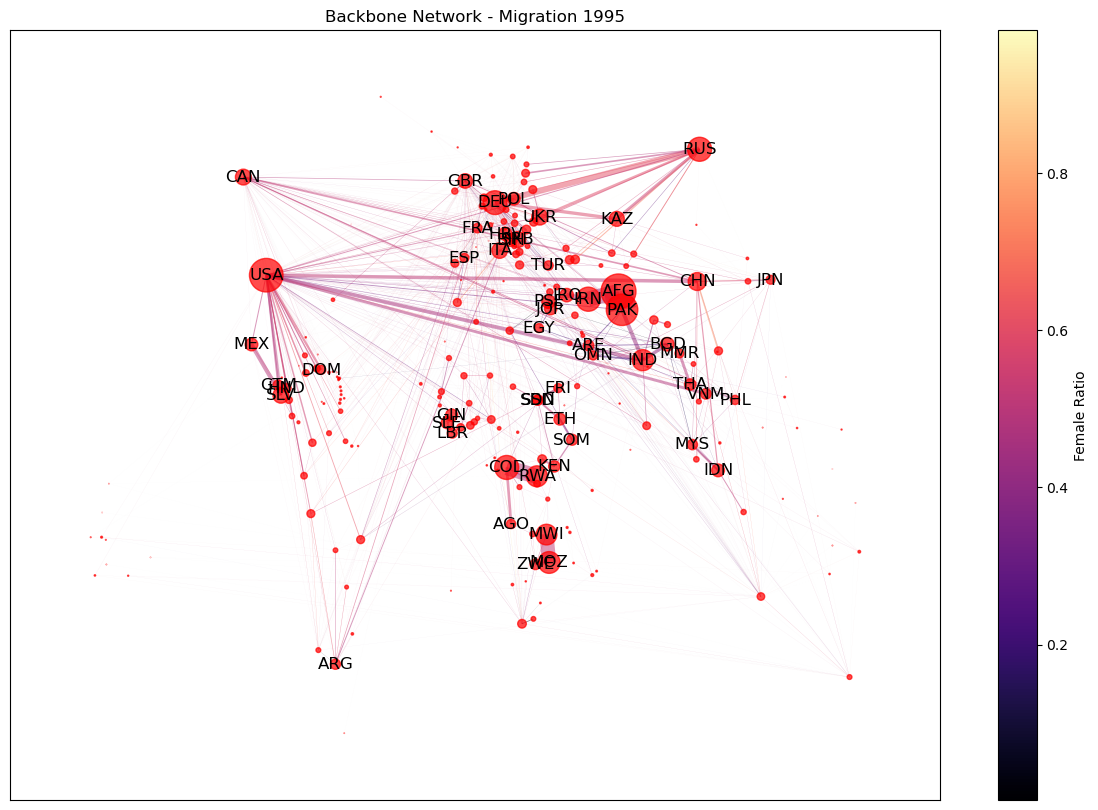

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def visualize_backbone_graph(graph, nodes_df, title):
    # Calculate node sizes based on degree and weight
    node_sizes = [graph.degree(n, weight='weight')/5000 for n in graph.nodes()]
    edge_weights = [d['weight'] / 100000 for _, _, d in graph.edges(data=True)]

    # Position, size, and labels
    node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graph.nodes}
    labels = get_high_degree_labels(graph, nodes_df, 200000)

    # Edge colors based on female ratio
    female_ratios = np.array([d['female_ratio'] for _, _, d in graph.edges(data=True)])
    norm = mcolors.Normalize(vmin=female_ratios.min(), vmax=female_ratios.max())
    cmap = plt.get_cmap('magma')
    edge_colors = [cmap(norm(d['female_ratio'])) for _, _, d in graph.edges(data=True)]

    # Visualization
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_sizes, node_color='red', alpha=0.7)
    nx.draw_networkx_edges(graph, node_positions, width=edge_weights, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(graph, node_positions, labels=labels, font_size=12)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical', label='Female Ratio')
    plt.show()

# Visualize the first backbone network
visualize_backbone_graph(backbone_graphs[0], nodes_df, "Backbone Network - Migration 1995")


### Plotting the Degree distribution of BB graphs

In [9]:
import collections

def calculate_degree_distribution(graph):
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # Degree for each node
    degree_count = collections.Counter(degree_sequence)  # Counts the frequency of each degree value
    deg, cnt = zip(*degree_count.items())

    return deg, cnt


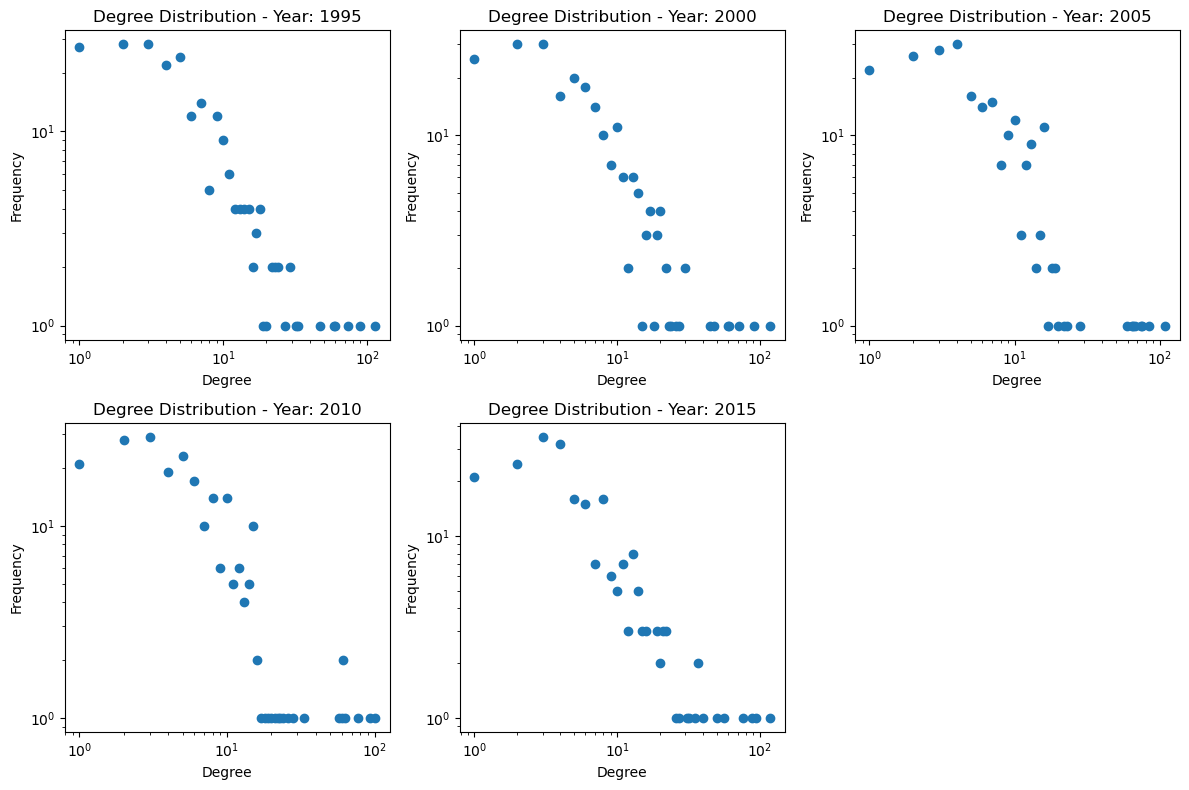

In [10]:
import matplotlib.pyplot as plt

# Years for the x-axis
years = [1995, 2000, 2005, 2010, 2015]

# Assuming backbone_graphs is a list of your backbone network graphs
plt.figure(figsize=(12, 8))

for i, graph in enumerate(backbone_graphs):
    deg, cnt = calculate_degree_distribution(graph)
    
    # Plotting
    plt.subplot(2, 3, i+1)  # Adjust subplot grid as necessary
    plt.plot(deg, cnt, marker='o', linestyle='None')
    plt.xscale('log')
    plt.yscale('log')
    # adding year to the title
    plt.title(f'Degree Distribution - Year: {years[i]}')    
    plt.xlabel('Degree')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


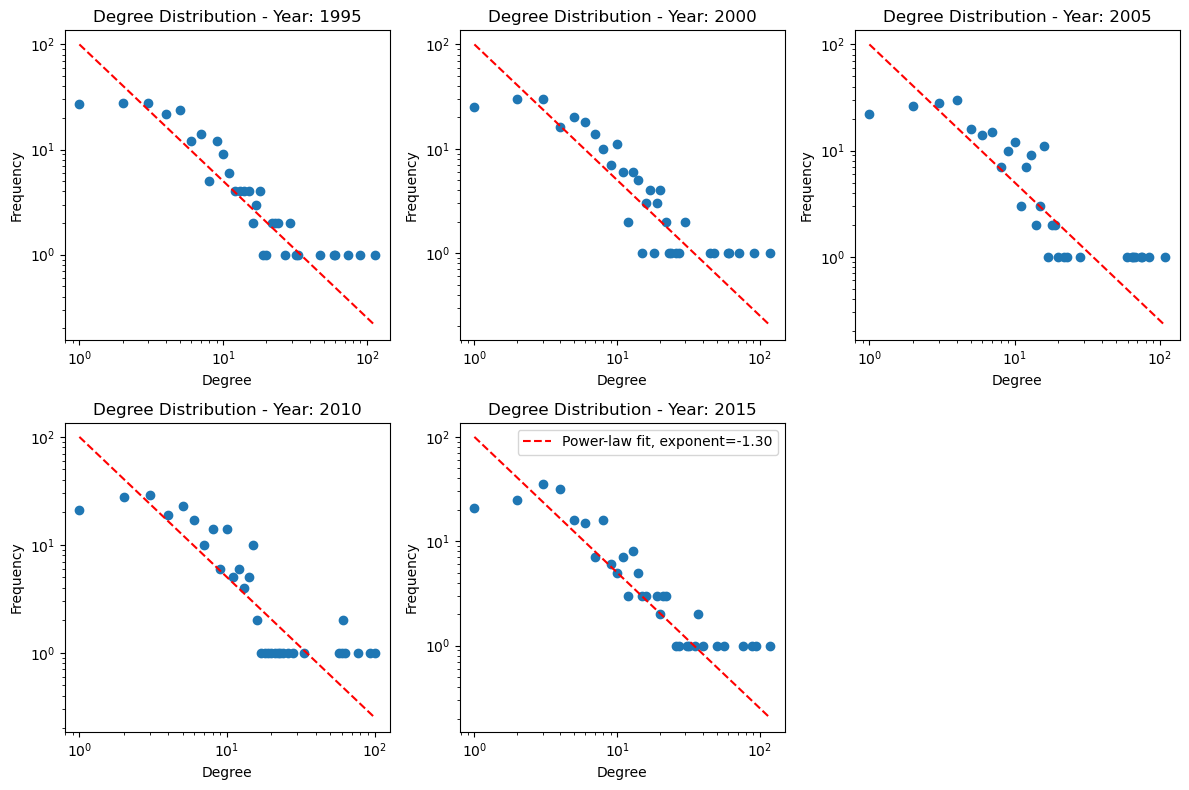

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import collections

def plot_power_law_line(ax, min_deg, max_deg, exponent, coefficient):
    x = np.linspace(min_deg, max_deg, 100)
    y = coefficient * (x ** exponent)
    ax.plot(x, y, label=f"Power-law fit, exponent={exponent:.2f}", linestyle='--', color='red')

# Assuming backbone_graphs is a list of your backbone network graphs
plt.figure(figsize=(12, 8))

for i, graph in enumerate(backbone_graphs):
    deg, cnt = calculate_degree_distribution(graph)
    
    # Plotting the degree distribution
    ax = plt.subplot(2, 3, i+1)  # Adjust subplot grid as necessary
    ax.plot(deg, cnt, marker='o', linestyle='None')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Degree Distribution - Year: {years[i]}') 
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')

    # Adding a theoretical power-law line
    # Exponent and coefficient values should be adjusted to fit your data
    plot_power_law_line(ax, min(deg), max(deg), exponent=-1.3, coefficient=100)

plt.tight_layout()
plt.legend()
plt.show()


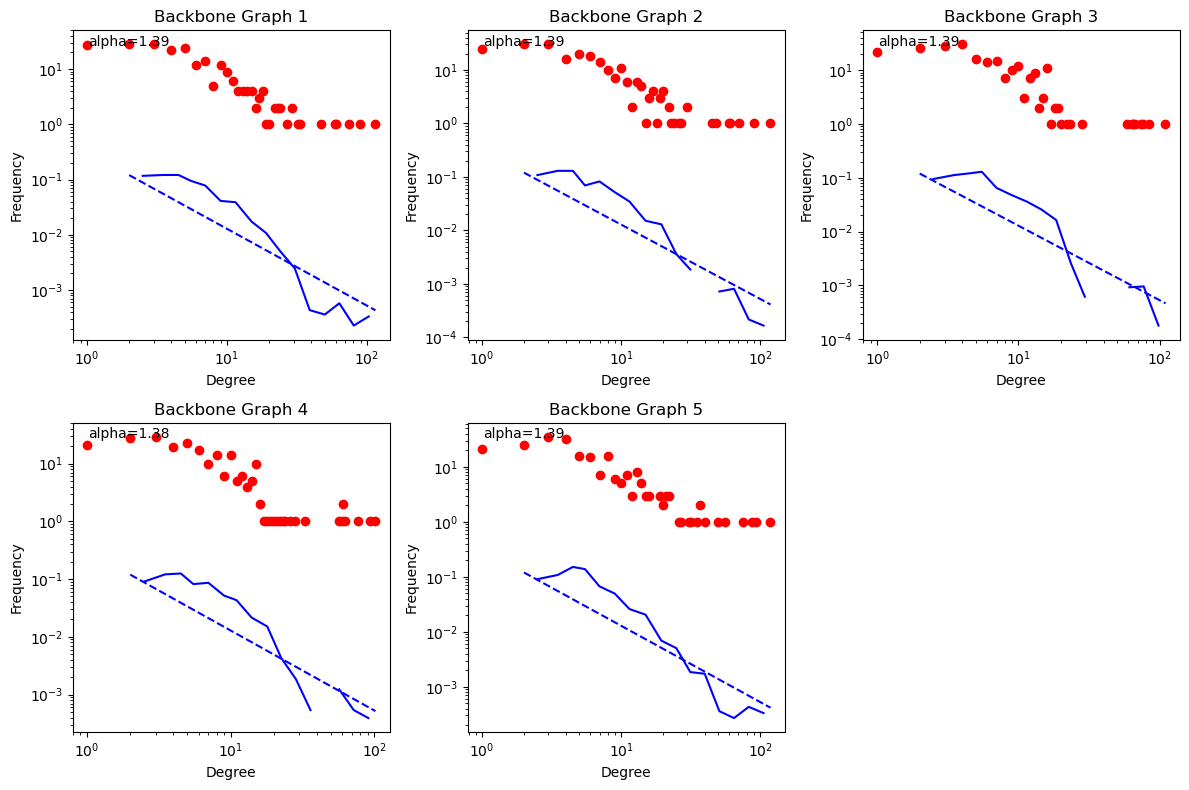

In [12]:
import powerlaw
import matplotlib.pyplot as plt
import numpy as np
import collections

# Function to plot the degree distribution and power-law fit
def plot_degree_distribution_with_power_law_fit(graph, ax, graph_index):
    # Calculate the degree distribution
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
    degree_count = collections.Counter(degree_sequence)
    deg, cnt = zip(*degree_count.items())

    # Fit the data to a power-law distribution
    fit = powerlaw.Fit(np.array(degree_sequence) + 1, xmin=1, discrete=True)
    fit.power_law.plot_pdf(color='b', linestyle='--', ax=ax)
    fit.plot_pdf(color='b', ax=ax)

    # Plotting
    ax.scatter(deg, cnt, color='r')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'Backbone Graph {graph_index}')
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')

    # Displaying the power-law exponent
    ax.text(0.05, 0.95, f'alpha={fit.power_law.alpha:.2f}', transform=ax.transAxes)

# Assuming backbone_graphs is a list of your backbone network graphs
plt.figure(figsize=(12, 8))

for i, graph in enumerate(backbone_graphs):
    ax = plt.subplot(2, 3, i+1)  # Adjust subplot grid as necessary
    plot_degree_distribution_with_power_law_fit(graph, ax, i+1)

plt.tight_layout()
plt.show()


### Plotting the number of edges in BB network for each year

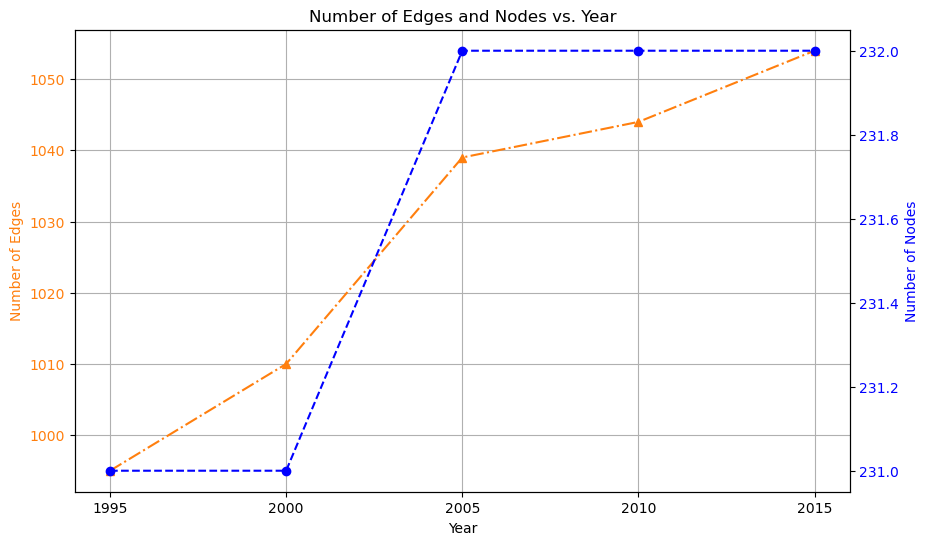

In [13]:
import matplotlib.pyplot as plt

# Years for the x-axis
years = [1995, 2000, 2005, 2010, 2015]

# Creating the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the number of edges on the primary y-axis
ax1.plot(years, [graph.number_of_edges() for graph in backbone_graphs], color='#ff7f0e', marker='^', linestyle='-.', label='Number of edges')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Edges', color='#ff7f0e')
ax1.tick_params(axis='y', labelcolor='#ff7f0e')

# Setting x-axis ticks and labels
ax1.set_xticks(years)

# Creating a secondary y-axis for the number of nodes
ax2 = ax1.twinx()
ax2.plot(years, [graph.number_of_nodes() for graph in backbone_graphs], color='blue', marker='o', linestyle='--', label='Number of nodes')
ax2.set_ylabel('Number of Nodes', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Adding a title and grid
plt.title('Number of Edges and Nodes vs. Year')
ax1.grid(True)

# Showing the plot
plt.show()


### Assortativity: Plotting the K_nn against k

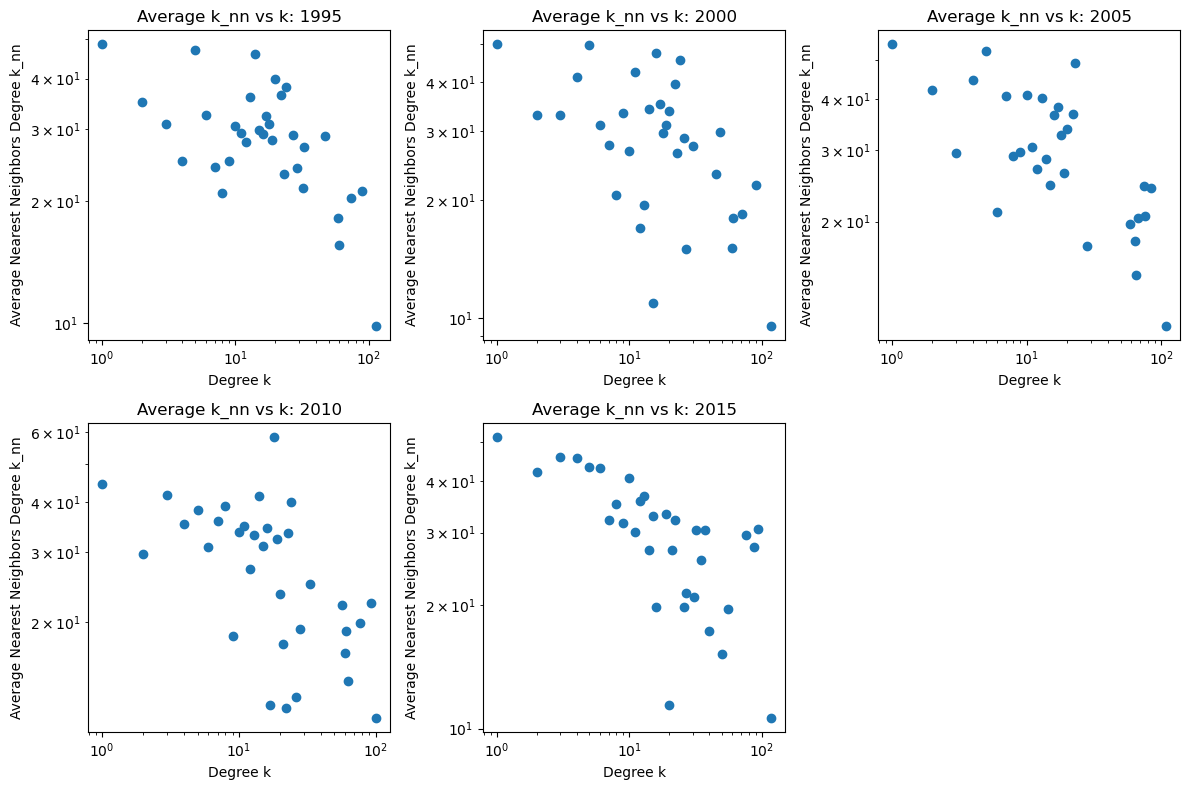

In [14]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_knn_vs_k(graph, ax):
    knn_dict = nx.average_neighbor_degree(graph, weight='weight')  # k_nn for each node
    degree_dict = dict(graph.degree())  # Degree of each node

    # Aggregate k_nn values by degree
    knn_by_degree = {}
    for node, degree in degree_dict.items():
        if degree not in knn_by_degree:
            knn_by_degree[degree] = []
        knn_by_degree[degree].append(knn_dict[node])

    # Compute the average k_nn for each degree
    avg_knn_by_degree = {k: sum(v) / len(v) for k, v in knn_by_degree.items()}

    # Plotting
    ax.scatter(avg_knn_by_degree.keys(), avg_knn_by_degree.values())
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Degree k')
    ax.set_ylabel('Average Nearest Neighbors Degree k_nn')
    ax.set_title(f'Average k_nn vs k: {years[i]}')

# Assuming backbone_graphs is a list of your backbone network graphs
plt.figure(figsize=(12, 8))

for i, graph in enumerate(backbone_graphs):
    ax = plt.subplot(2, 3, i+1)  # Adjust subplot grid as necessary
    plot_knn_vs_k(graph, ax)

plt.tight_layout()
plt.show()


* adding the reference line:

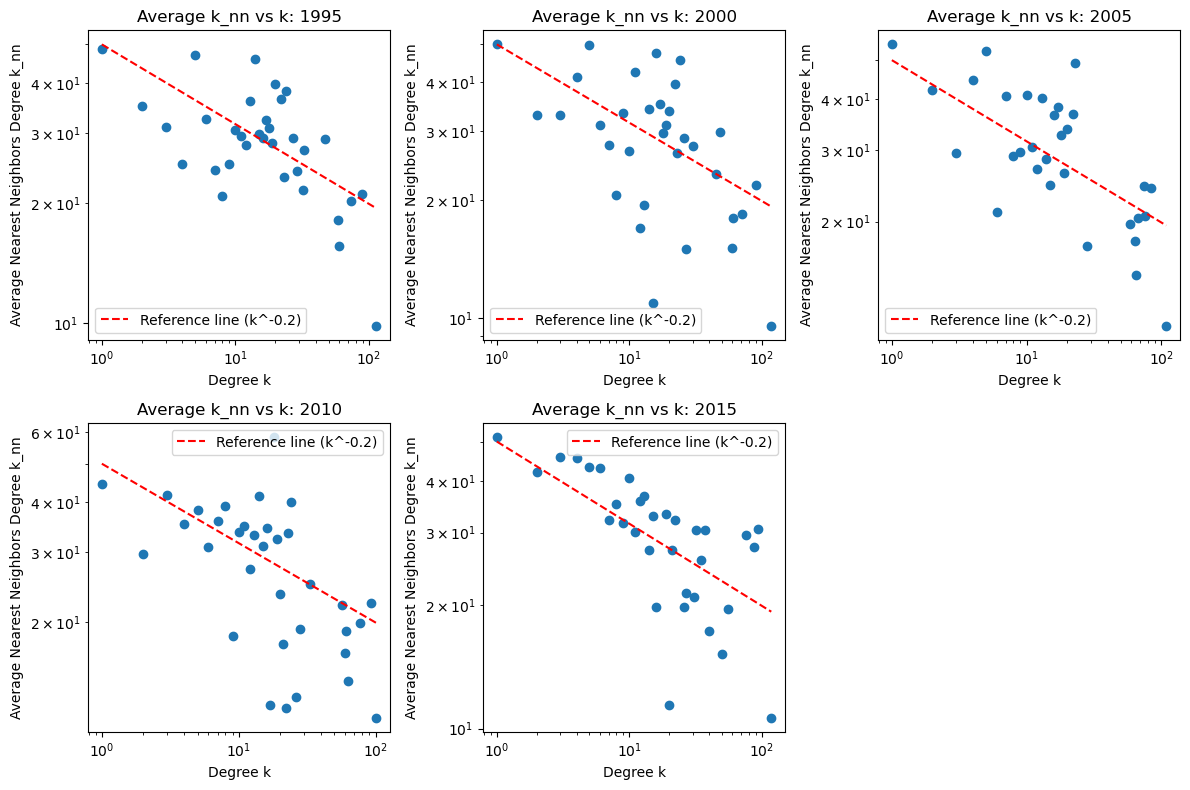

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_knn_vs_k_with_reference(graph, ax, exponent=1.0):
    knn_dict = nx.average_neighbor_degree(graph, weight='weight')
    degree_dict = dict(graph.degree())

    # Aggregate k_nn values by degree
    knn_by_degree = {}
    for node, degree in degree_dict.items():
        if degree not in knn_by_degree:
            knn_by_degree[degree] = []
        knn_by_degree[degree].append(knn_dict[node])

    avg_knn_by_degree = {k: sum(v) / len(v) for k, v in knn_by_degree.items()}

    # Plotting
    ax.scatter(avg_knn_by_degree.keys(), avg_knn_by_degree.values())
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Degree k')
    ax.set_ylabel('Average Nearest Neighbors Degree k_nn')
    ax.set_title(f'Average k_nn vs k: {years[i]}')

    # Adding a reference line (e.g., a power-law line)
    max_degree = max(avg_knn_by_degree.keys())
    x = np.linspace(1, max_degree, 100)
    y = 50* (x ** exponent)
    ax.plot(x, y, label=f"Reference line (k^{exponent})", linestyle='--', color='red')
    ax.legend()

# Assuming backbone_graphs is a list of your backbone network graphs
plt.figure(figsize=(12, 8))

for i, graph in enumerate(backbone_graphs):
    ax = plt.subplot(2, 3, i+1)  # Adjust subplot grid as necessary
    plot_knn_vs_k_with_reference(graph, ax, exponent=-.2)  # Adjust exponent as needed

plt.tight_layout()
plt.show()


* Average Clustering and average shortest path:

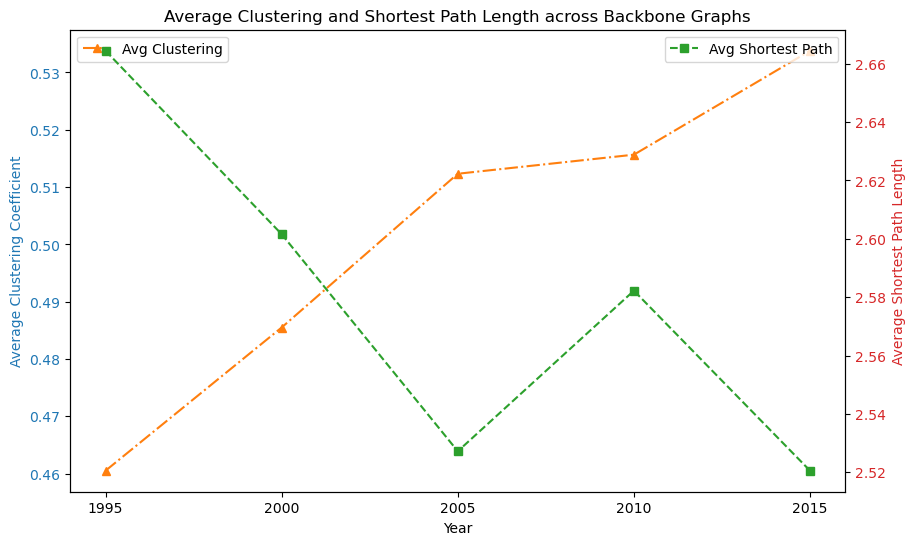

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

# Years for the x-axis
years = [1995, 2000, 2005, 2010, 2015]

# Lists to store the metrics
average_clustering = []
average_shortest_path = []

for graph in backbone_graphs:
    # Compute the average clustering coefficient
    avg_clust = nx.average_clustering(graph)
    average_clustering.append(avg_clust)

    # Compute the average shortest path length
    if nx.is_connected(graph):
        avg_path_len = nx.average_shortest_path_length(graph)
    else:
        # Consider the largest connected component for disconnected graphs
        largest_cc = max(nx.connected_components(graph), key=len)
        subgraph = graph.subgraph(largest_cc).copy()
        avg_path_len = nx.average_shortest_path_length(subgraph)

    average_shortest_path.append(avg_path_len)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# First y-axis for average clustering
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Clustering Coefficient', color='tab:blue')
ax1.plot(years, average_clustering, color='#ff7f0e', marker='^', linestyle='-.', label='Avg Clustering')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Setting x-axis ticks and labels
ax1.set_xticks(years)

# Second y-axis for average shortest path
ax2 = ax1.twinx()
ax2.set_ylabel('Average Shortest Path Length', color='tab:red')
ax2.plot(years, average_shortest_path, color='#2ca02c', marker='s', linestyle='--', label='Avg Shortest Path')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Average Clustering and Shortest Path Length across Backbone Graphs')
plt.show()


### Community detection using Clauset-Newman-Moore method

In [17]:
import networkx as nx
import pandas as pd

# Detect communities in each backbone network using Clauset-Newman-Moore method
communities = []
for graph in backbone_graphs:
    communities_gen = nx.community.greedy_modularity_communities(graph)
    # Convert the result to a dictionary form similar to what the Louvain method returns
    partition = {node: cid for cid, community in enumerate(communities_gen) for node in community}
    communities.append(partition)

# For the first backbone graph, print the list of the 'name' of the nodes in each community
first_graph_communities = communities[0]

# Inverting the partition dictionary to group by community
communities_nodes = {}
for node, comm_id in first_graph_communities.items():
    communities_nodes.setdefault(comm_id, []).append(node)

# Printing the list of nodes (by 'name' attribute) in each community
for comm_id, nodes in communities_nodes.items():
    print(f"Community {comm_id}: {[backbone_graphs[0].nodes[node]['name'] for node in nodes]}")


Community 0: ['DZA', 'AND', 'ARG', 'AUT', 'BEL', 'BLZ', 'BOL', 'BIH', 'BRA', 'BGR', 'CPV', 'CAN', 'CHL', 'CHN', 'COL', 'CRI', 'HRV', 'CUB', 'DNK', 'DOM', 'ECU', 'SLV', 'FRO', 'FIN', 'DEU', 'GRL', 'GTM', 'GUY', 'HTI', 'HND', 'HUN', 'ISL', 'IRN', 'ISR', 'ITA', 'JAM', 'JPN', 'LIE', 'LUX', 'MLT', 'MHL', 'MEX', 'MNE', 'MAR', 'NLD', 'NIC', 'NOR', 'PAN', 'PRY', 'PER', 'PRT', 'PRI', 'KOR', 'MDA', 'ROU', 'SMR', 'SRB', 'SYC', 'SVN', 'ESP', 'SUR', 'SWE', 'CHE', 'MKD', 'TUN', 'TUR', 'USA', 'URY', 'VEN', 'ESH']
Community 1: ['AFG', 'AGO', 'MOZ', 'NAM', 'OMN', 'PAK', 'BDI', 'QAT', 'CAF', 'TCD', 'RWA', 'COG', 'SAU', 'COD', 'DJI', 'SOM', 'EGY', 'SSD', 'PSE', 'ERI', 'SDN', 'ETH', 'SYR', 'TLS', 'UGA', 'ARE', 'TZA', 'IDN', 'IRQ', 'YEM', 'ZMB', 'ZWE', 'JOR', 'KEN', 'KWT', 'LBN', 'LBY', 'MWI']
Community 2: ['MTQ', 'ASM', 'MUS', 'MYT', 'AUS', 'NRU', 'NCL', 'NZL', 'NIU', 'BWA', 'PNG', 'REU', 'HKG', 'MAC', 'COM', 'WSM', 'COK', 'CZE', 'SGP', 'SVK', 'ZAF', 'LKA', 'SWZ', 'FJI', 'FRA', 'GUF', 'PYF', 'TKL', 'TON',

### Community detection using Louvain method

In [18]:
import community as community_louvain

community_assignments = []

for graph in backbone_graphs:
    partition = community_louvain.best_partition(graph, weight='weight')
    community_assignments.append(partition)

# Now, for the first backbone graph, print the names of the nodes in each community
first_graph_partition = community_assignments[0]
first_graph_communities = {}

for node, community in first_graph_partition.items():
    first_graph_communities.setdefault(community, []).append(graph.nodes[node]['name'])

for community, nodes in first_graph_communities.items():
    print(f"Community {community}: {nodes}")


Community 0: ['AFG', 'IRN', 'PAK', 'IRQ']
Community 1: ['ALB', 'ITA', 'DZA', 'ISR', 'FRA', 'AND', 'ESP', 'ARG', 'BOL', 'PRY', 'URY', 'ABW', 'CHE', 'BEL', 'NLD', 'COM', 'MYT', 'CUW', 'GLP', 'REU', 'MTQ', 'GUF', 'NCL', 'PYF', 'LIE', 'MDG', 'MUS', 'MCO', 'MAR', 'WLF', 'SMR', 'SXM', 'SUR', 'TUN', 'VUT', 'ESH']
Community 2: ['GRC', 'DEU', 'ARM', 'AZE', 'RUS', 'UKR', 'TUR', 'CZE', 'POL', 'SVK', 'SWE', 'BLR', 'KAZ', 'LVA', 'LTU', 'HUN', 'BGR', 'ROU', 'PRK', 'DNK', 'FRO', 'GRL', 'EST', 'FIN', 'NOR', 'GEO', 'ISL', 'KGZ', 'TJK', 'MNG', 'MDA', 'TKM', 'UZB', 'MKD']
Community 10: ['GBR', 'CAN', 'USA', 'ASM', 'WSM', 'PRT', 'AUS', 'AIA', 'BES', 'MEX', 'CHL', 'PER', 'CHN', 'HKG', 'JPN', 'SGP', 'IRL', 'MLT', 'NZL', 'PNG', 'PHL', 'BRA', 'BHS', 'TCA', 'BRB', 'LUX', 'BLZ', 'BMU', 'VIR', 'VGB', 'CPV', 'STP', 'KHM', 'VNM', 'KOR', 'CYM', 'CIN', 'VEN', 'MAC', 'COL', 'ECU', 'COK', 'CRI', 'SLV', 'NIC', 'CUB', 'CYP', 'DMA', 'DOM', 'PRI', 'GTM', 'HND', 'FLK', 'FJI', 'GIB', 'GRD', 'TTO', 'GUM', 'MNP', 'PLW', 'GUY'

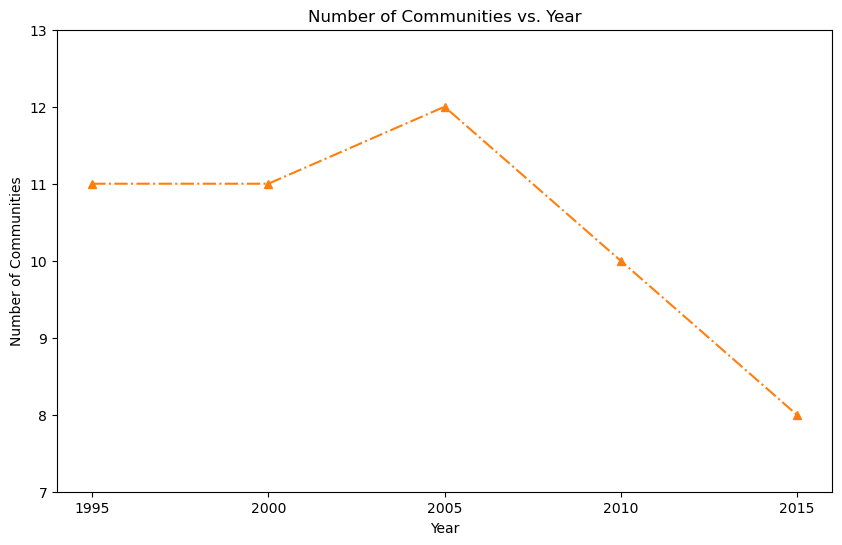

In [110]:
# plotting the number of communities vs. year
plt.figure(figsize=(10, 6))
plt.plot(years, [len(set(comm.values())) for comm in community_assignments], color='#ff7f0e', marker='^', linestyle='-.', label='Number of edges in BB network')
plt.xlabel('Year')
plt.xticks(years)
plt.yticks(range(7, 14))
plt.ylabel('Number of Communities')
plt.title('Number of Communities vs. Year')
plt.show()

### Visualizing the BB network by separate colors for each community

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import community as community_louvain

# Assuming 'graph' is your backbone network and 'partition' is the community assignment
def get_community_color_map(graph, partition):
    # Get unique communities
    unique_communities = set(partition.values())

    # Generate as many colors as there are communities
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))

    # Assign colors to communities
    community_color = {comm: colors[i] for i, comm in enumerate(unique_communities)}

    # Map each node to the color of its community
    node_color_map = [community_color[partition[node]] for node in graph.nodes()]
    return node_color_map


In [21]:
def visualize_graph_with_communities(graph, nodes_df, partition, title):
    node_sizes = [graph.degree(n, weight='weight')/5000 for n in graph.nodes()]
    edge_weights = [d['weight'] / 100000 for _, _, d in graph.edges(data=True)]

    # Position, size, and labels
    node_positions = {row['Label']: (row['lng'], row['lat']) for index, row in nodes_df.iterrows() if row['Label'] in graph.nodes}
    labels = get_high_degree_labels(graph, nodes_df, 200000)

    # Get the color map for communities
    node_color_map = get_community_color_map(graph, partition)

    # Edge colors based on female ratio
    female_ratios = np.array([d['female_ratio'] for _, _, d in graph.edges(data=True)])
    norm = mcolors.Normalize(vmin=female_ratios.min(), vmax=female_ratios.max())
    cmap = plt.get_cmap('magma')
    edge_colors = [cmap(norm(d['female_ratio'])) for _, _, d in graph.edges(data=True)]

    # Visualization
    plt.figure(figsize=(15, 10))
    nx.draw_networkx_nodes(graph, node_positions, node_size=node_sizes, node_color=node_color_map, alpha=0.7)
    nx.draw_networkx_edges(graph, node_positions, width=edge_weights, alpha=0.5, edge_color=edge_colors)
    nx.draw_networkx_labels(graph, node_positions, labels=labels, font_size=12)
    plt.title(title)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), orientation='vertical', label='Female Ratio')
    plt.show()


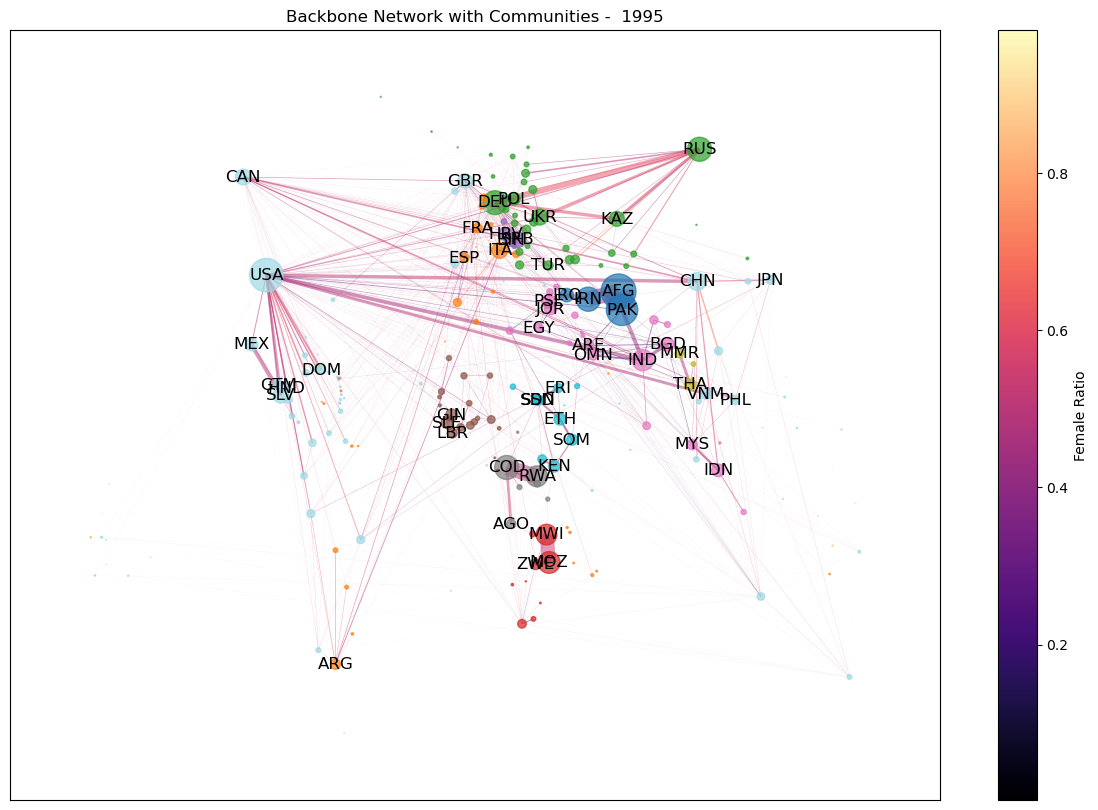

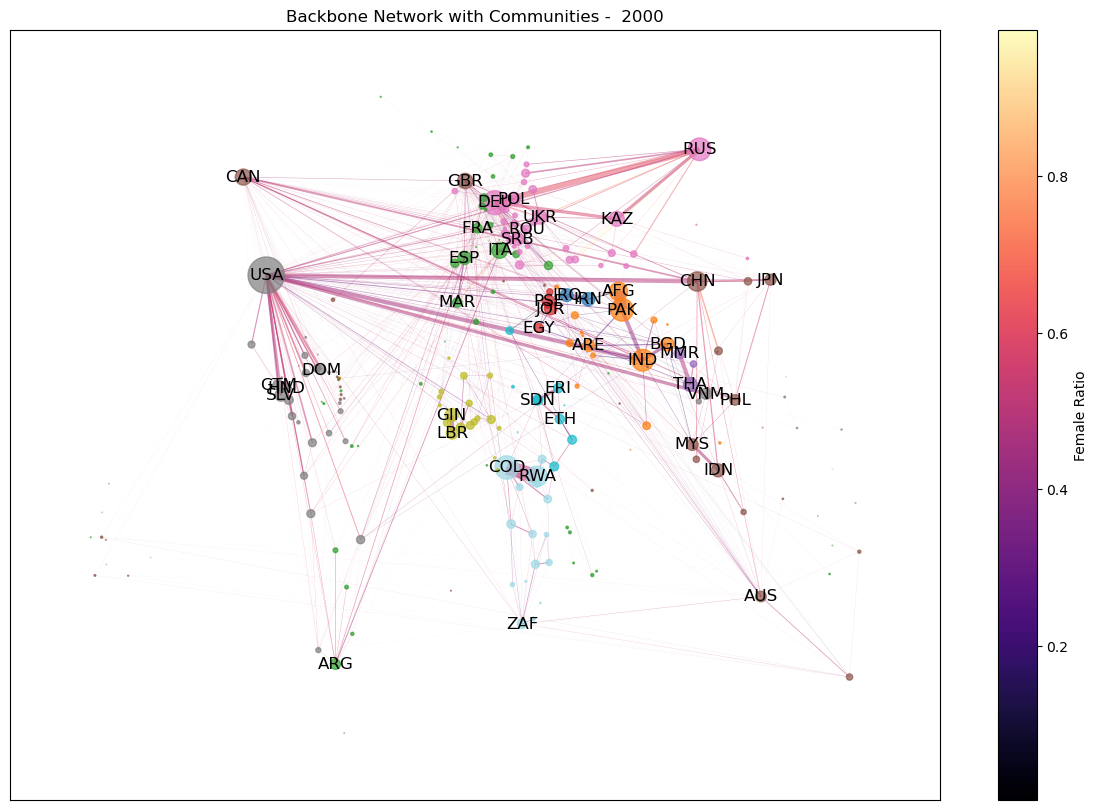

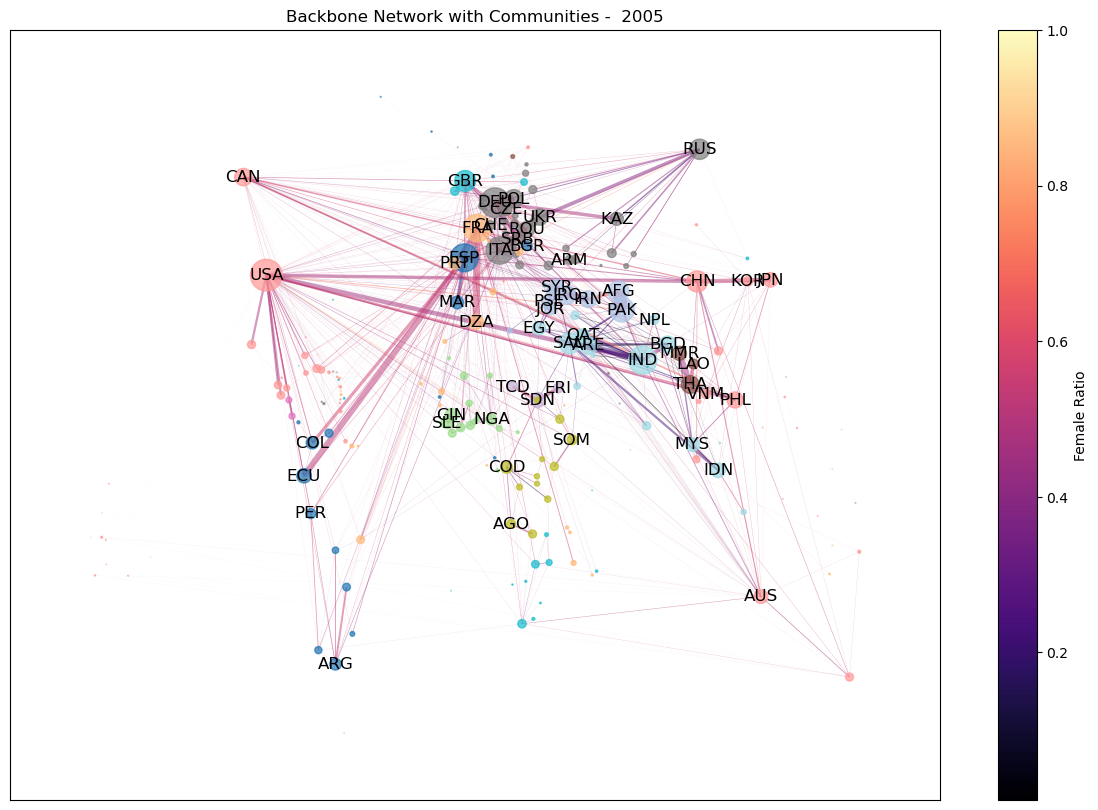

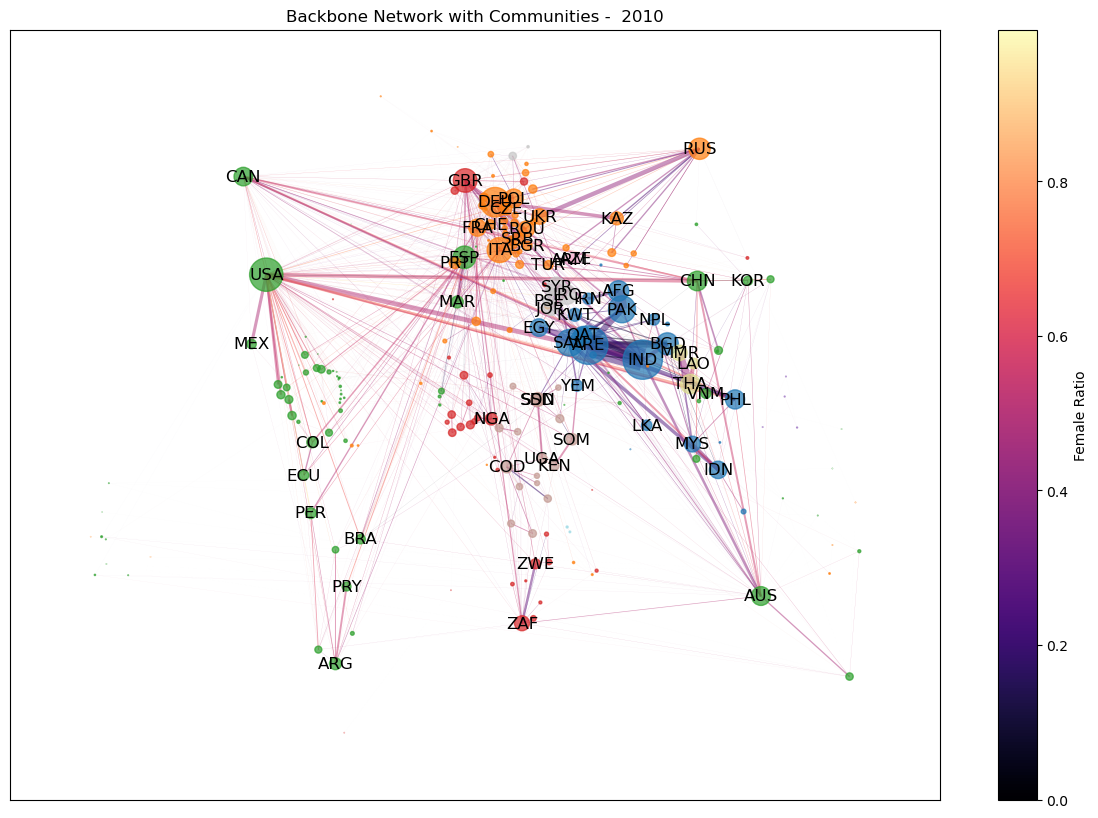

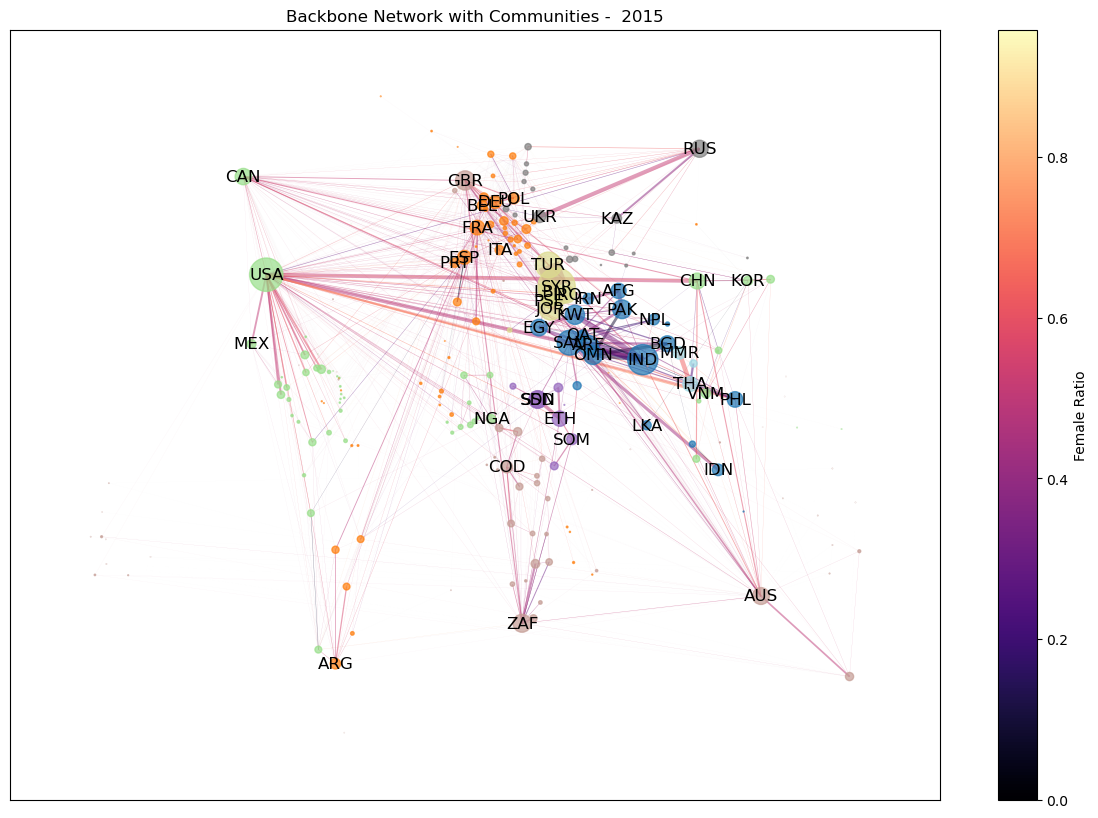

In [22]:
# Loop through each backbone graph and its community partition
for i, (graph, partition) in enumerate(zip(backbone_graphs, community_assignments)):
    visualize_graph_with_communities(graph, nodes_df, partition, f"Backbone Network with Communities -  {years[i]}")


### Tracking the communities of the nodes with highest weight in first BB network

In [23]:
def get_node_with_highest_weight(graph, community_nodes):
    highest_weight_node = None
    highest_weight = 0

    for node in community_nodes:
        node_weight = sum(weight for _, _, weight in graph.edges(node, data='weight'))
        if node_weight > highest_weight:
            highest_weight = node_weight
            highest_weight_node = node

    return highest_weight_node

# First, find the highest weight node in each community of the first backbone graph
first_graph_partition = community_assignments[0]
first_graph_communities = {}

for node, community in first_graph_partition.items():
    first_graph_communities.setdefault(community, []).append(node)

highest_weight_nodes = {}
for community, nodes in first_graph_communities.items():
    highest_weight_node = get_node_with_highest_weight(backbone_graphs[0], nodes)
    if highest_weight_node is not None:
        highest_weight_nodes[community] = highest_weight_node

# Track these nodes in subsequent backbone graphs
community_changes = {}

for node in highest_weight_nodes.values():
    community_changes[node] = []

for i, graph in enumerate(backbone_graphs):
    partition = community_assignments[i]
    for node in highest_weight_nodes.values():
        if node in graph:
            community_changes[node].append(partition[node])
        else:
            community_changes[node].append(None)  # Placeholder if the node is not in the graph

# Print the community changes for each tracked node
for node, communities in community_changes.items():
    node_name = backbone_graphs[0].nodes[node]['name'] if node in backbone_graphs[0] else "Unknown"
    print(f"Node '{node_name}' (Community Changes): {communities}")


Node 'AFG' (Community Changes): [0, 1, 1, 0, 0]
Node 'ITA' (Community Changes): [1, 2, 8, 1, 1]
Node 'RUS' (Community Changes): [2, 6, 8, 1, 5]
Node 'USA' (Community Changes): [10, 7, 4, 2, 2]
Node 'COD' (Community Changes): [7, 10, 9, 5, 4]
Node 'MOZ' (Community Changes): [3, 10, 10, 3, 4]
Node 'IND' (Community Changes): [6, 1, 11, 0, 0]
Node 'SRB' (Community Changes): [4, 6, 8, 1, 1]
Node 'GIN' (Community Changes): [5, 8, 3, 3, 1]
Node 'THA' (Community Changes): [8, 4, 6, 8, 7]
Node 'ETH' (Community Changes): [9, 9, 9, 5, 3]


In [37]:
# find the node with the highest weight in each community of the last backbone graph
last_graph_partition = community_assignments[-1]
last_graph_communities = {}

for node, community in last_graph_partition.items():
    last_graph_communities.setdefault(community, []).append(node)

highest_weight_nodes = {}
for community, nodes in last_graph_communities.items():
    highest_weight_node = get_node_with_highest_weight(backbone_graphs[-1], nodes)
    if highest_weight_node is not None:
        highest_weight_nodes[community] = highest_weight_node

# Track these nodes in subsequent backbone graphs
community_changes = {}

for node in highest_weight_nodes.values():
    community_changes[node] = []

for i, graph in enumerate(backbone_graphs):
    partition = community_assignments[i]
    for node in highest_weight_nodes.values():
        if node in graph:
            community_changes[node].append(partition[node])
        else:
            community_changes[node].append(None)  # Placeholder if the node is not in the graph

# Print the community changes for each tracked node
for node, communities in community_changes.items():
    node_name = backbone_graphs[-1].nodes[node]['name'] if node in backbone_graphs[-1] else "Unknown"
    print(f"Node '{node_name}' (Community Changes): {communities}")



Node 'IND' (Community Changes): [6, 1, 11, 0, 0]
Node 'FRA' (Community Changes): [1, 2, 2, 1, 1]
Node 'USA' (Community Changes): [10, 7, 4, 2, 2]
Node 'GBR' (Community Changes): [10, 5, 10, 3, 4]
Node 'RUS' (Community Changes): [2, 6, 8, 1, 5]
Node 'SYR' (Community Changes): [6, 1, 1, 7, 6]
Node 'THA' (Community Changes): [8, 4, 6, 8, 7]
Node 'SSD' (Community Changes): [9, 9, 9, 5, 3]


### EI- Index: Globalization or Polarization

In [24]:
def calculate_external_internal_weight_degree(graph, partition):
    external_weights = {}
    internal_weights = {}
    external_degrees = {}
    internal_degrees = {}

    for node in graph.nodes():
        external_weights[node] = 0
        internal_weights[node] = 0
        external_degrees[node] = 0
        internal_degrees[node] = 0

        for neighbor in graph.neighbors(node):
            if partition[neighbor] != partition[node]:
                external_weights[node] += graph.edges[node, neighbor]['weight']
                external_degrees[node] += 1
            else:
                internal_weights[node] += graph.edges[node, neighbor]['weight']
                internal_degrees[node] += 1

    return external_weights, internal_weights, external_degrees, internal_degrees

In [25]:
# Calculate E-I index for degree and weight
def calculate_ei_index(graph, partition):
    external_weights, internal_weights, external_degrees, internal_degrees = calculate_external_internal_weight_degree(graph, partition)
    # total_external_weight, total_internal_wwight, total_external_degree, total_internal_degree = calculate_sums(graph, partition)
    ei_index_degree = {}
    ei_index_weight = {}
    for node in graph.nodes():
        ei_index_degree[node] = -(external_degrees[node] - internal_degrees[node]) / (external_degrees[node] + internal_degrees[node])
        ei_index_weight[node] = -(external_weights[node] - internal_weights[node]) / (external_weights[node] + internal_weights[node])
    return ei_index_degree, ei_index_weight

In [26]:
def calculate_community_ei_index(graph, partition):
    ei_index_degree, ei_index_weight = calculate_ei_index(graph, partition)

    # Initialize dictionaries to store total EI-indices and node counts per community
    community_ei_degree = {}
    community_ei_weight = {}
    community_node_count = {}

    # Aggregate EI-indices by community
    for node, comm_id in partition.items():
        community_ei_degree.setdefault(comm_id, 0)
        community_ei_weight.setdefault(comm_id, 0)
        community_node_count.setdefault(comm_id, 0)

        community_ei_degree[comm_id] += ei_index_degree[node]
        community_ei_weight[comm_id] += ei_index_weight[node]
        community_node_count[comm_id] += 1

    # Compute the average EI-index for each community
    avg_community_ei_degree = {comm: total_degree / community_node_count[comm] for comm, total_degree in community_ei_degree.items()}
    avg_community_ei_weight = {comm: total_weight / community_node_count[comm] for comm, total_weight in community_ei_weight.items()}

    return avg_community_ei_degree, avg_community_ei_weight

# Apply this function to each backbone network
for i, graph in enumerate(backbone_graphs):
    partition = community_assignments[i]  # Assuming community_assignments stores partitions for each graph
    avg_ei_degree, avg_ei_weight = calculate_community_ei_index(graph, partition)

    print(f"Backbone Network {i + 1}:")
    print("Average EI-Index by Degree:", avg_ei_degree)
    print("Average EI-Index by Weight:", avg_ei_weight)
    print("\n")


Backbone Network 1:
Average EI-Index by Degree: {0: -0.4126984126984127, 1: 0.19237394056578747, 2: 0.3526706159375824, 10: 0.6714337977311333, 7: 0.08027210884353744, 3: 0.48326947637292467, 6: 0.16801285312905465, 4: -0.04509379509379508, 5: 0.5645302228635563, 8: 0.13333333333333333, 9: 0.2766666666666667}
Average EI-Index by Weight: {0: 0.7123059680645765, 1: 0.5690394158559625, 2: 0.6258612385851476, 10: 0.8202054579102441, 7: 0.6598069225921469, 3: 0.8335523912143307, 6: 0.5143370391742293, 4: 0.40327362893286867, 5: 0.7465041560304625, 8: 0.6720202807851777, 9: 0.7552097478841312}


Backbone Network 2:
Average EI-Index by Degree: {1: -0.0879015071997528, 0: -0.75, 2: 0.281470594018017, 6: 0.3402960649500441, 5: 0.49192979657615293, 7: 0.3284802091740651, 10: 0.6045828141736069, 9: 0.1991769547325103, 8: 0.48112874779541454, 4: 0.11111111111111112, 3: -0.5995670995670995}
Average EI-Index by Weight: {1: 0.41378059004948947, 0: 0.35292166453410084, 2: 0.5632116762030148, 6: 0.6377

In [70]:
calculate_community_ei_index(backbone_graphs[0], community_assignments[0])[1][6]

0.5143370391742293

In [95]:
# storing the community_changes in a dataframe in a way that each row is a node and each column is a year
df = pd.DataFrame(community_changes)
df = df.transpose()
df.columns = years

# adding the name of the node to the dataframe
df['name'] = [backbone_graphs[-1].nodes[node]['name'] if node in backbone_graphs[-1] else "Unknown" for node in df.index]

# adding the EI-index columns to the dataframe: EI-1995, EI-2000, EI-2005, EI-2010, EI-2015 
df['EI-1995'] = 0
df['EI-2000'] = 0
df['EI-2005'] = 0
df['EI-2010'] = 0
df['EI-2015'] = 0

# replacing the zeros with the EI-index values
for i in df.index:
    j = df.at[i, 1995]
    df.at[i, 'EI-1995'] = calculate_community_ei_index(backbone_graphs[0], community_assignments[0])[1][j]
    j = df.at[i, 2000]
    df.at[i, 'EI-2000'] = calculate_community_ei_index(backbone_graphs[1], community_assignments[1])[1][j]
    j = df.at[i, 2005]
    df.at[i, 'EI-2005'] = calculate_community_ei_index(backbone_graphs[2], community_assignments[2])[1][j]
    j = df.at[i, 2010]
    df.at[i, 'EI-2010'] = calculate_community_ei_index(backbone_graphs[3], community_assignments[3])[1][j]
    j = df.at[i, 2015]
    df.at[i, 'EI-2015'] = calculate_community_ei_index(backbone_graphs[4], community_assignments[4])[1][j]
df

1995  2000  2005  2010  2015 name   EI-1995   EI-2000   EI-2005  \
97      6     1    11     0     0  IND  0.514337  0.413781  0.480126   
74      1     2     2     1     1  FRA  0.569039  0.563212  0.619312   
220    10     7     4     2     2  USA  0.820205  0.676695  0.622283   
218    10     5    10     3     4  GBR  0.820205  0.651168  0.410154   
170     2     6     8     1     5  RUS  0.625861  0.637763  0.615427   
201     6     1     1     7     6  SYR  0.514337  0.413781  0.527132   
203     8     4     6     8     7  THA  0.672020  0.727521  0.415163   
192     9     9     9     5     3  SSD  0.755210  0.534542  0.644911   

      EI-2010   EI-2015  
97   0.657847  0.697112  
74   0.638980  0.626266  
220  0.694324  0.664490  
218  0.560845  0.677310  
170  0.638980  0.434649  
201  0.293992  0.805946  
203  0.741495  0.758589  
192  0.606107  0.528362

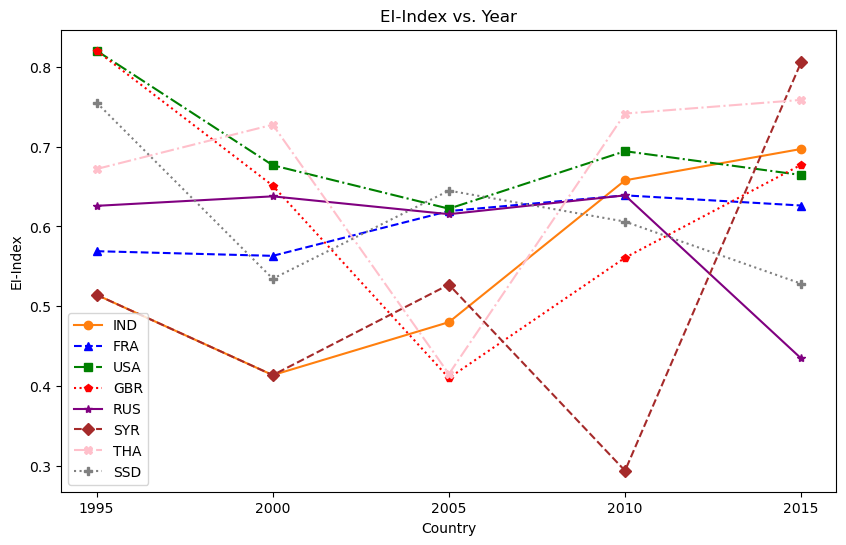

In [103]:
# plotting the EI-index of each node against the year
plt.figure(figsize=(10, 6))
color_list = ['#ff7f0e', 'blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray']
marker_list = ['o', '^', 's', 'p', '*', 'D', 'X', 'P']
line_list = ['-', '--', '-.', ':', '-', '--', '-.', ':']
for i, j in zip(df.index, range(len(df))):
    plt.plot(years, df.loc[i ,['EI-1995', 'EI-2000', 'EI-2005', 'EI-2010', 'EI-2015']].tolist(), color=color_list[j] , marker=marker_list[j] , linestyle= line_list[j] , label=df.loc[i, 'name'])

plt.xlabel('Country')
plt.xticks(years)
plt.ylabel('EI-Index')
plt.title('EI-Index vs. Year')
plt.legend()
plt.show()


### Homophily measurement:

Homophily in the context of network communities can be understood as the tendency of nodes to be connected to others within the same community.

One way to measure homophily in a network is by comparing the actual intra-community edges (edges within communities) against the expected number of such edges if the network's edges were randomly distributed.

This can be done using the modularity measure, which is often used to evaluate the quality of community partitions in a network.

Homophily in Backbone Graph 1: 0.702788189146598
Homophily in Backbone Graph 2: 0.6454376271914681
Homophily in Backbone Graph 3: 0.5977846958892983
Homophily in Backbone Graph 4: 0.5754483388700639
Homophily in Backbone Graph 5: 0.6414240616645057


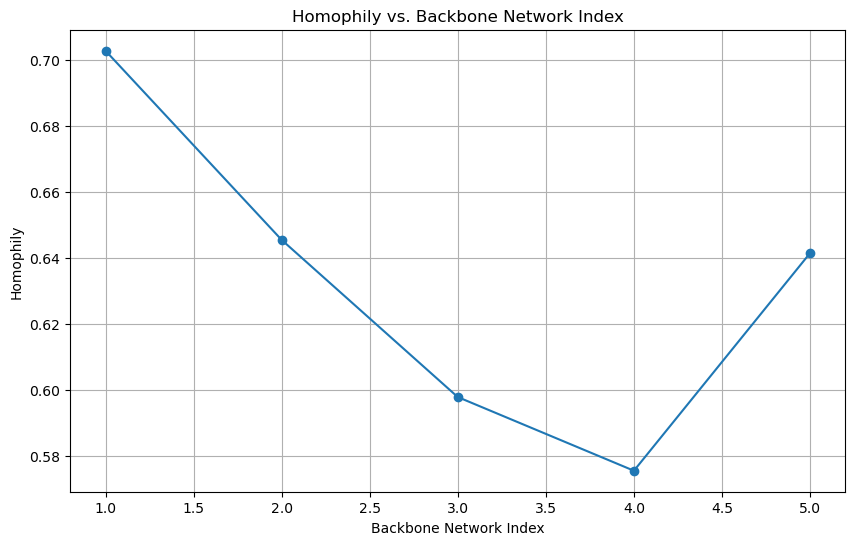

In [106]:
def measure_homophily(graph, partition):
    # Convert partition to list of node sets
    communities = []
    for community_id in set(partition.values()):
        community_nodes = {node for node, comm_id in partition.items() if comm_id == community_id}
        communities.append(community_nodes)

    # Calculate modularity
    modularity = nx.algorithms.community.modularity(graph, communities)
    return modularity

# Calculate and print homophily for each backbone graph
for i, graph in enumerate(backbone_graphs):
    partition = community_assignments[i]  # Assuming this contains community partitions
    homophily = measure_homophily(graph, partition)
    print(f"Homophily in Backbone Graph {i + 1}: {homophily}")

# plotting the homophily against the backbone network index
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6, 1), [measure_homophily(graph, partition) for graph, partition in zip(backbone_graphs, community_assignments)], marker='o')
plt.xlabel('Backbone Network Index')
plt.ylabel('Homophily')
plt.title('Homophily vs. Backbone Network Index')
plt.grid(True)
plt.show()



In this code:

The measure_homophily function calculates the modularity of the graph given a community partition, which serves as a proxy for homophily.

This function is applied to each backbone graph, and the resulting homophily (modularity) scores are printed.

Higher modularity scores indicate that the edges within communities are denser than expected in a random network, suggesting a higher level of homophily.

C:\Users\PA\AppData\Local\Temp\ipykernel_3052\1090585818.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



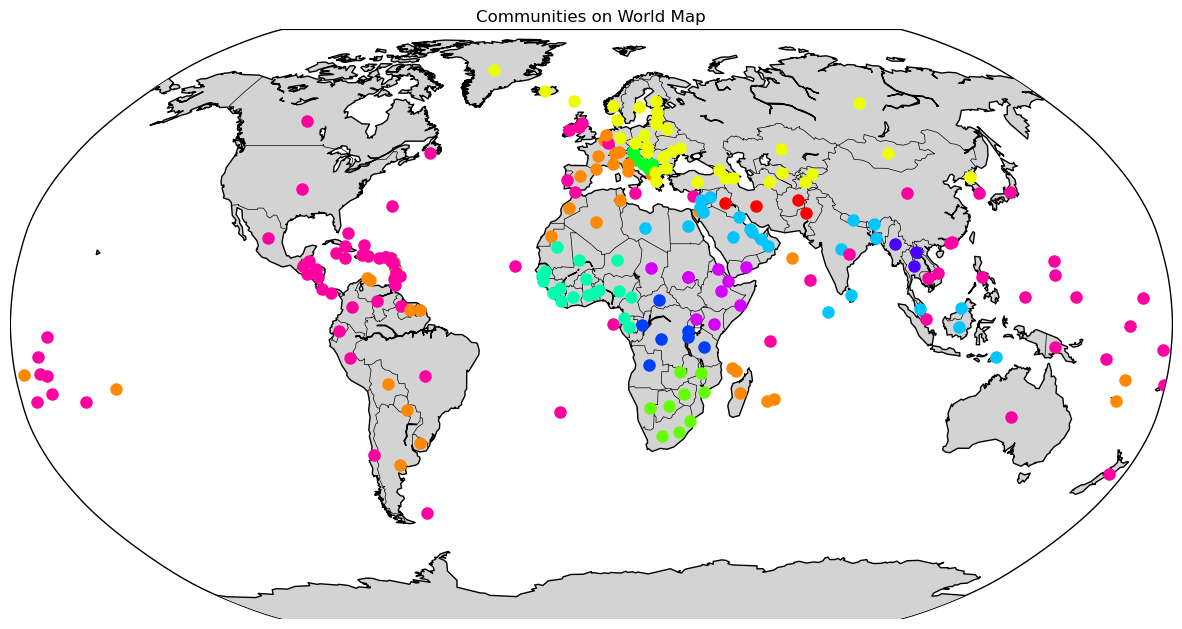

In [107]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def plot_communities_on_map(graph, partition, nodes_df):
    # Create a Basemap instance
    plt.figure(figsize=(15, 8))
    m = Basemap(projection='robin', lon_0=0, resolution='c')

    # Draw coastlines, countries, and continents
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='lightgray', lake_color='white')

    # Define a color map for the communities
    community_colors = plt.cm.get_cmap('hsv', len(set(partition.values())) + 1)

    # Plot each node in the graph
    for node in graph.nodes():
        x, y = m(nodes_df.loc[node, 'lng'], nodes_df.loc[node, 'lat'])  # Assuming 'lng' and 'lat' columns in nodes_df
        m.plot(x, y, marker='o', color=community_colors(partition[node]), markersize=8)

    plt.title('Communities on World Map')
    plt.show()

# Apply this function to one of the backbone graphs and its community partition
plot_communities_on_map(backbone_graphs[0], community_assignments[0], nodes_df)


C:\Users\PA\AppData\Local\Temp\ipykernel_3052\1090585818.py:15: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



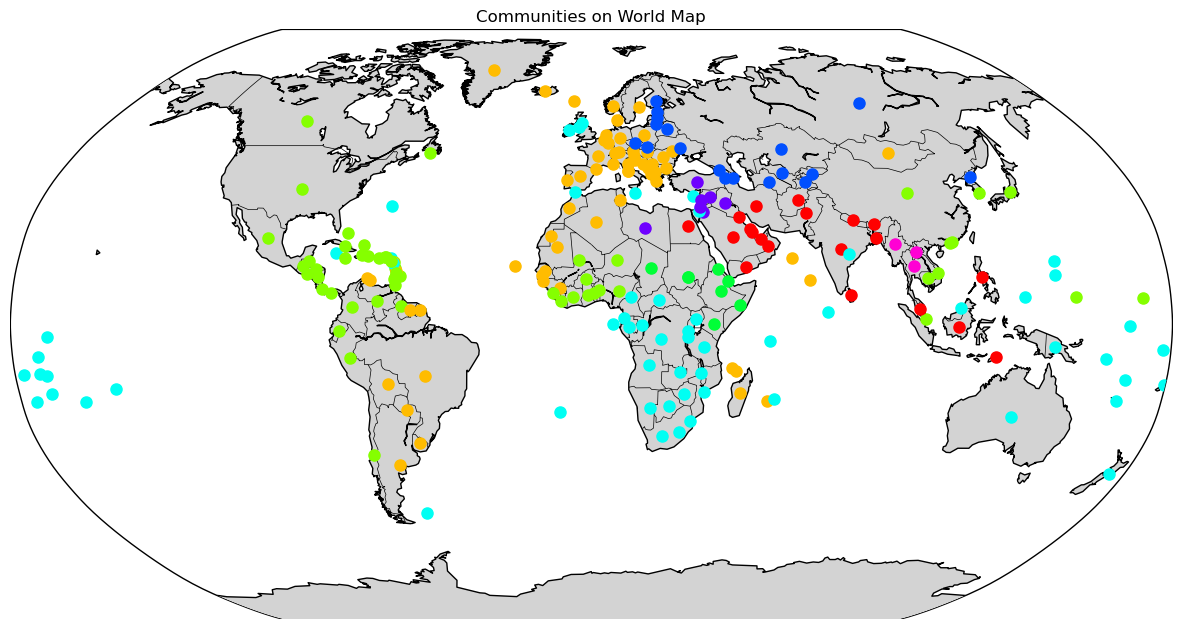

In [108]:
plot_communities_on_map(backbone_graphs[-1], community_assignments[-1], nodes_df)

In [30]:
# adding the community assignment for each year in migration_years to the nodes_df
for i, year in enumerate(migration_years):
    nodes_df[year] = pd.Series(community_assignments[i])

nodes_df.columns

Index(['Label', 'name', 'code', 'region', 'sub_region', '_pos', 'lat', 'lng',
       'Abb', 'migration_1995_total', 'migration_2000_total',
       'migration_2005_total', 'migration_2010_total', 'migration_2015_total'],
      dtype='object')

In [31]:
# changing the column names to the number included in the migration year
nodes_df = nodes_df.rename(columns={'migration_1995_total': '1995', 'migration_2000_total': '2000', 'migration_2005_total': '2005', 'migration_2010_total': '2010', 'migration_2015_total': '2015'})

In [32]:
nodes_df.head()

Label            name  code   region       sub_region  \
0      0     Afghanistan     4     Asia    Southern Asia   
1      1         Albania     8   Europe  Southern Europe   
2      2         Algeria    12   Africa  Northern Africa   
3      3  American Samoa    16  Oceania        Polynesia   
4      4         Andorra    20   Europe  Southern Europe   

                              _pos        lat         lng  Abb  1995  2000  \
0  array([1.83174148, 1.86242262])  33.939110   67.709953  AFG   0.0   1.0   
1  array([1.89105956, 2.05459683])  41.153332   20.168331  ALB   1.0   2.0   
2  array([1.90130528, 1.98917661])  28.033886    1.659626  DZA   1.0   2.0   
3  array([1.97167436, 2.13972604]) -14.270972 -170.132217  ASM  10.0   5.0   
4  array([1.70167317, 1.89743272])  42.546245    1.601554  AND   1.0   2.0   

   2005  2010  2015  
0     1     0     0  
1     8     1     1  
2     2     1     1  
3     4     2     4  
4     0     2     1

In [33]:
# saving the nodes_df to a csv file
nodes_df.to_csv('nodes_with_communities.csv', index=False)

In [34]:
# Collapsing the year columns into a single 'year' column
# and creating 'community_number' column with corresponding values
melted_nodes_df = pd.melt(nodes_df, id_vars=['Label', 'name', 'code', 'region', 'sub_region', '_pos', 'lat', 'lng', 'Abb'], 
                    value_vars=['1995', '2000', '2005', '2010', '2015'], 
                    var_name='year', value_name='community_number')

# Displaying the first few rows of the transformed dataframe
melted_nodes_df.head()

Label            name  code   region       sub_region  \
0      0     Afghanistan     4     Asia    Southern Asia   
1      1         Albania     8   Europe  Southern Europe   
2      2         Algeria    12   Africa  Northern Africa   
3      3  American Samoa    16  Oceania        Polynesia   
4      4         Andorra    20   Europe  Southern Europe   

                              _pos        lat         lng  Abb  year  \
0  array([1.83174148, 1.86242262])  33.939110   67.709953  AFG  1995   
1  array([1.89105956, 2.05459683])  41.153332   20.168331  ALB  1995   
2  array([1.90130528, 1.98917661])  28.033886    1.659626  DZA  1995   
3  array([1.97167436, 2.13972604]) -14.270972 -170.132217  ASM  1995   
4  array([1.70167317, 1.89743272])  42.546245    1.601554  AND  1995   

   community_number  
0               0.0  
1               1.0  
2               1.0  
3              10.0  
4               1.0

In [35]:
import plotly.express as px
import pandas as pd

# Create basic choropleth map
fig = px.choropleth(melted_nodes_df, locations='Abb', color='community_number', hover_name='name',
                    projection='natural earth', animation_frame='year',
                    title='Community Assignments by Country')
fig.show()

In [36]:
# storing the figure as an aniimated html file
fig.write_html("community_assignments.html")